In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: None]


In [1]:
!pip install kaggle
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import timm
import os
from pathlib import Path
import zipfile
import random
import shutil
from fastkaggle import *
from fastai.vision.all import *
from fastcore.parallel import *
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [3]:
creds='{"username":"aliesal12","key":"xxxxxxxxxxxxxxxxxxxxxxxxxx"}'

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
path = '/content/potato-plant-diseases-data'

# Downloading Data


In [6]:
!kaggle datasets download -d hafiznouman786/potato-plant-diseases-data

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
License(s): CC0-1.0
 98% 74.0M/75.7M [00:03<00:00, 28.9MB/s]
100% 75.7M/75.7M [00:03<00:00, 21.8MB/s]


In [7]:
zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
foldernames = os.listdir('/content/potato-plant-diseases-data/PotatoPlants')
type(foldernames)

list

# Splitting Test and Training Set

In [9]:
for i in foldernames:
  sourcepath=f'/content/potato-plant-diseases-data/PotatoPlants/{i}'
  destinationpath=f'/content/potato-plant-diseases-data/traintest/test/{i}'
  filenames=os.listdir(sourcepath)
  try:
    os.makedirs(destinationpath)
  except OSError:
    pass
  print(len(filenames))
  for j in range(int(len(filenames)*0.2)):
    ftc=random.randint(0, len(filenames)-1)
    source_file = os.path.join(sourcepath, filenames[ftc])
    destination_file = os.path.join(destinationpath, filenames[ftc])
    shutil.copy2(source_file, destination_file)
    filenames.pop(ftc)
  destinationpath=f'/content/potato-plant-diseases-data/traintest/train/{i}'
  print(len(filenames))
  try:
    os.makedirs(destinationpath)
  except OSError:
    pass
  for j in range(len(filenames)):
    source_file = os.path.join(sourcepath, filenames[j])
    destination_file = os.path.join(destinationpath, filenames[j])
    try:
      shutil.copy2(source_file, destination_file)
    except OSError:
      pass

1000
800
152
122
1000
800


# Loading Training Data


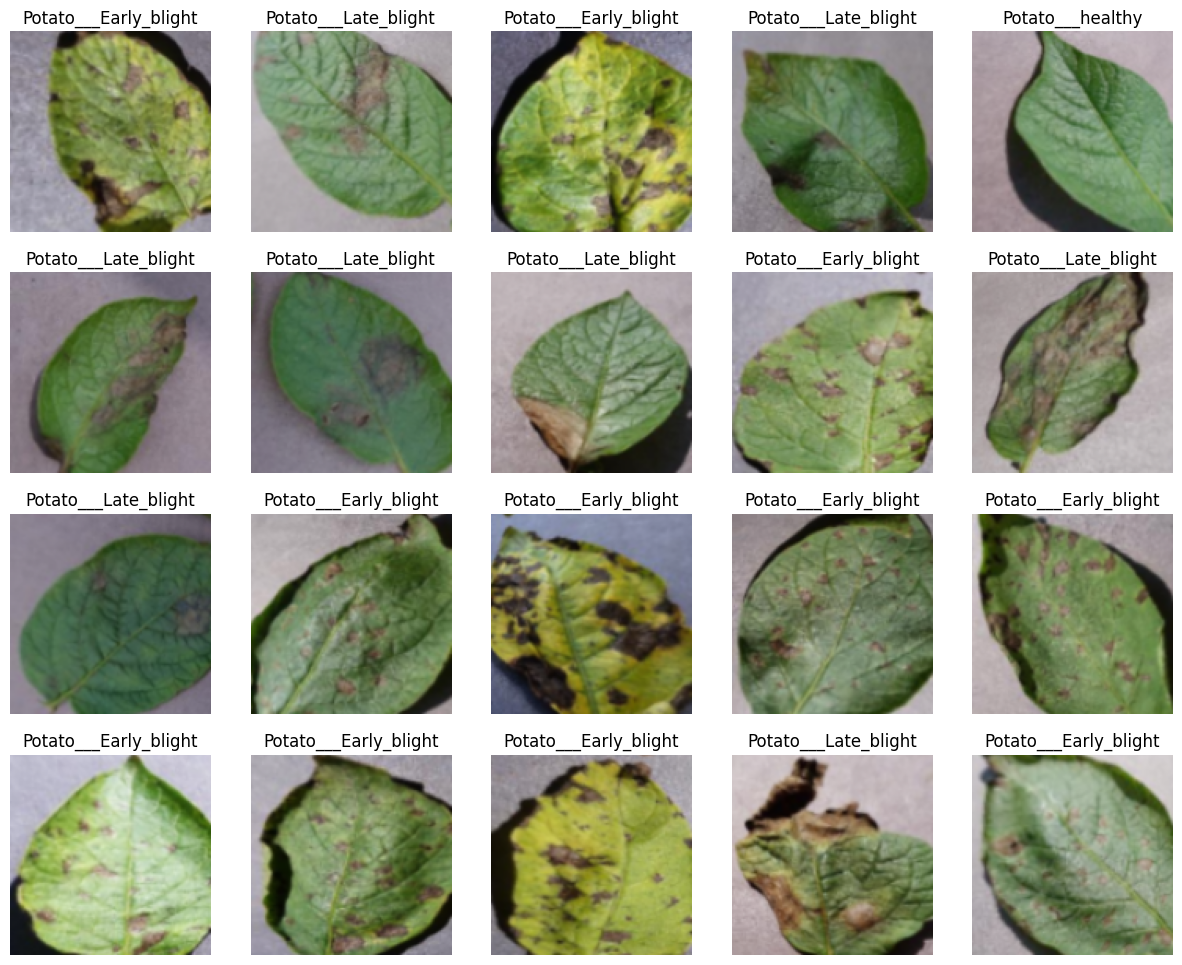

In [10]:
dls = ImageDataLoaders.from_folder('/content/potato-plant-diseases-data/traintest/train', valid_pct=0.2, seed=42, label_delim=' ',
    item_tfms=Resize(128, method='pad'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=20)

In [ ]:
# 'vit_small_patch16_224.augreg_in21k_ft_in1k' 'swin_small_patch4_window7_224.ms_in22k_ft_in1k'

# Selecting and Fine Tuning Multiple Models

In [12]:
models=['regnety_008.pycls_in1k','convnext_tiny.in12k_ft_in1k_384','resnet50.a1_in1k','mobilevit_s.cvnets_in1k','resnetv2_101.a1h_in1k']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/25.2M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

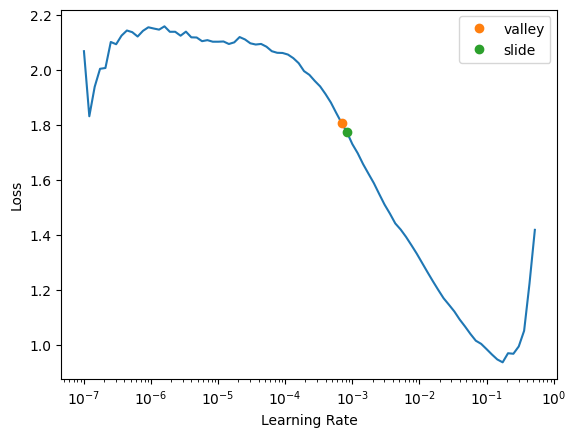

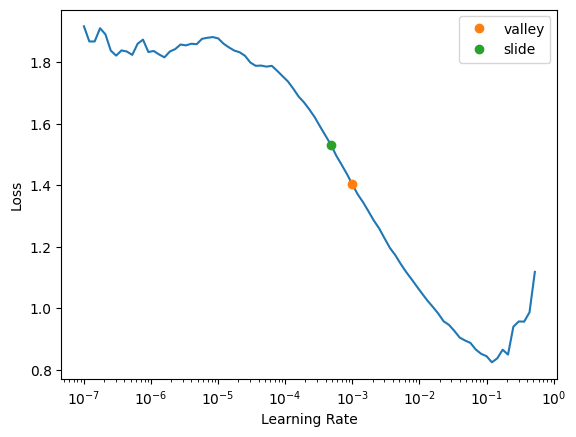

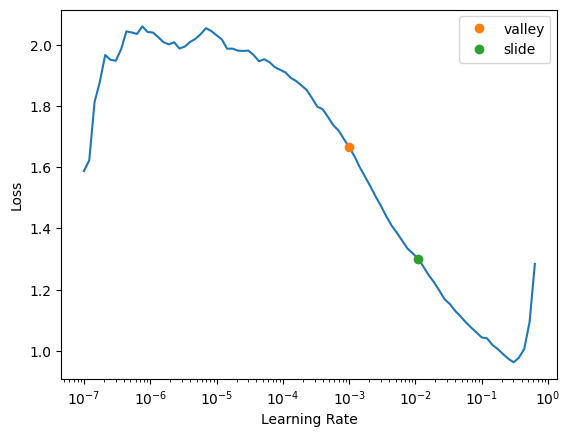

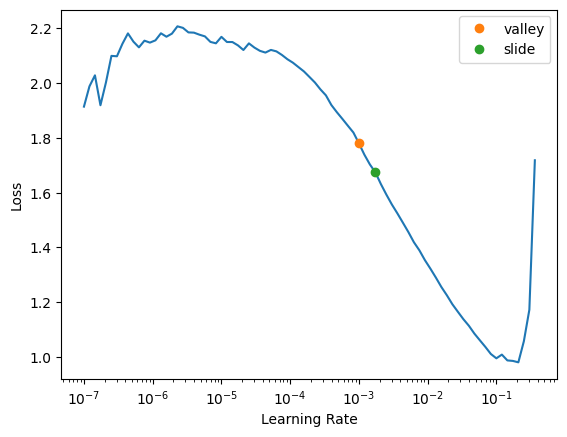

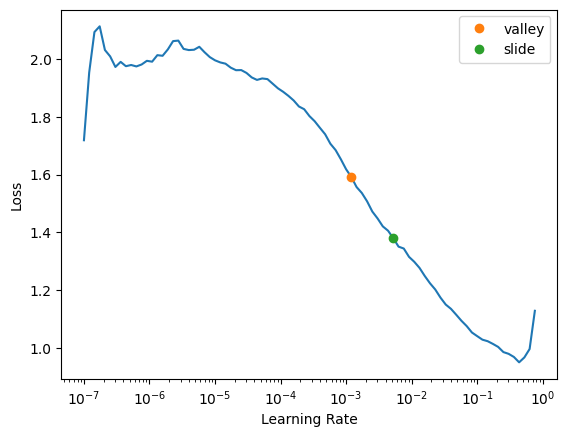

In [13]:
learners=[]
for model in models:
  learn = vision_learner(dls, model, metrics=error_rate, path='.').to_fp16()
  slide_val=learn.lr_find(suggest_funcs=(valley, slide))
  lr=float((slide_val.slide+slide_val.valley)/2)
  learn.fine_tune(10, lr)
  learners.append(learn)

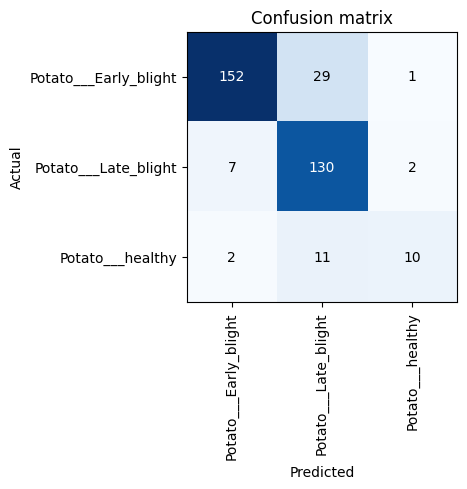

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

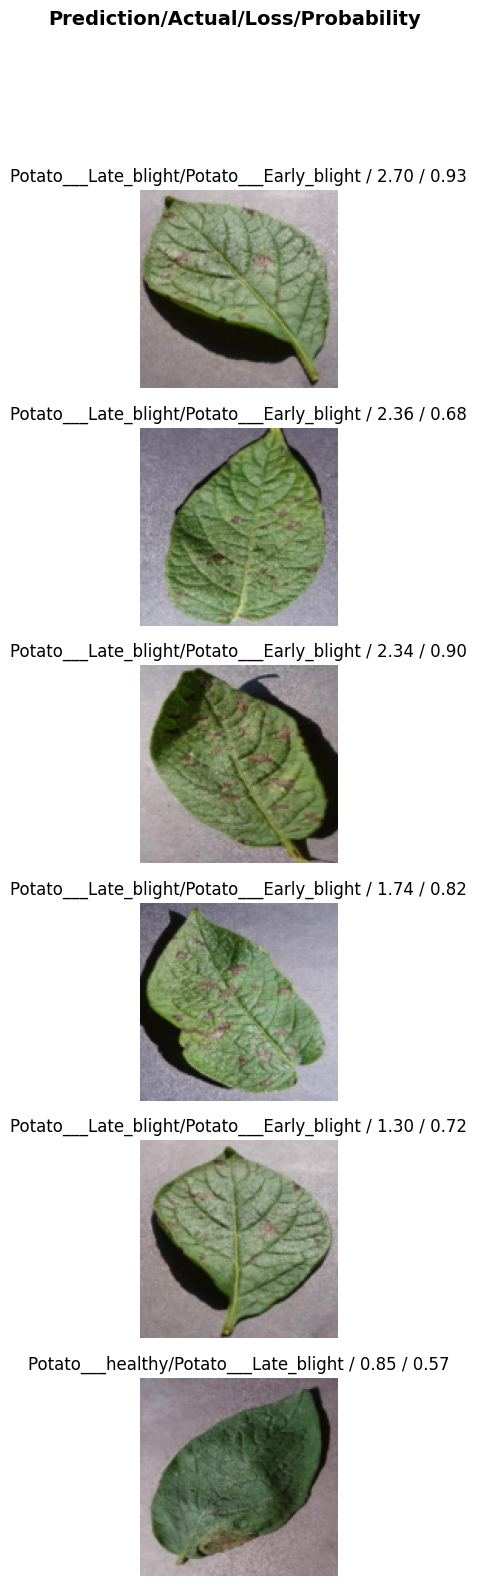

In [ ]:
#interp.plot_top_losses(6, nrows=6)

# Loading Test Set Data and making predictions



In [15]:
foldernames = os.listdir('/content/potato-plant-diseases-data/traintest/test')
all_items=[]
for foldername in foldernames:
  filenames=os.listdir(f'/content/potato-plant-diseases-data/traintest/test/{foldername}')
  all_items=all_items+[f'/content/potato-plant-diseases-data/traintest/test/{foldername}/'+i for i in filenames]
df=pd.DataFrame(all_items, columns=['filepath'])
df['Target']=np.where(df['filepath'].str.contains('RS_LB'),1,np.where(df['filepath'].str.contains('RS_HL'),2,0))

In [16]:
def predict(path):
  global learners
  preds=[]
  for learner in learners:
    prediction,predicted_class,probs = learner.predict(PILImage.create(path))
    preds.append(int(predicted_class))
  return preds

In [17]:
df['predictions']=df['filepath'].apply(predict)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


# Selecting predictions with most votes


In [20]:
df['final_predictions']=df['predictions'].apply(lambda x: stats.mode(x)[0])
df

filepath  \
0          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/6d51bd53-2556-410c-b151-547c83a06287___RS_LB 3276.JPG   
1          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/1c207156-339d-4ec9-9153-9edb3bc95b5f___RS_LB 4833.JPG   
2          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/b8b4064f-208a-46f9-b13e-5096fdbdb429___RS_LB 2591.JPG   
3          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/12ce2ab1-14c4-4960-81d4-e6ae776510e9___RS_LB 2880.JPG   
4          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/456f2c6a-a8c8-4dac-9de1-73668e39cd01___RS_LB 3008.JPG   
5          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/7a4371b2-72c6-414e-b73e-6e4b4adab72f___RS_LB 3289.JPG   
6          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/f528b00d-99a6-41db-8d96-9eed58b519c1___RS_LB 4544.JPG   
7          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/7ce28b45-467c-4962-a030-f621b4bc76a8___RS_LB 2644.JPG   
8          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/58475c1a-a4c2-43bd-b361-60523b5c62d2___RS_LB 3912.JPG   
9          /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/5b3de8b6-0690-4a35-ab9d-ef6617c548ff___RS_LB 2925.JPG   
10         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/5a42a288-8be0-4985-9ca5-105f75c8ee01___RS_LB 3275.JPG   
11         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/eb34280e-0cfb-4166-a9b8-a15892c9ff5c___RS_LB 4450.JPG   
12         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/1e0326a5-b208-447f-9d60-f788ec4b6e3f___RS_LB 4526.JPG   
13         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/5d1486fa-750f-47ca-a973-abc45ea5b4fe___RS_LB 4281.JPG   
14         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/0e7f0484-16eb-4183-b702-0a5b4f94d015___RS_LB 4000.JPG   
15         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/63490f84-88b0-4105-bb76-23990e98c692___RS_LB 3041.JPG   
16         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/3f2d7c62-8d58-4a40-9df4-0ab3497b13b9___RS_LB 4487.JPG   
17         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/319335dc-6a48-4fe4-932b-326f1455f3cd___RS_LB 4703.JPG   
18         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/6fea732f-0819-4ba1-922a-8cbb1a94baff___RS_LB 3336.JPG   
19         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/f4e0bb0f-5f98-497c-a090-4e4c47f6707b___RS_LB 5153.JPG   
20         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/3f6bce87-fb66-44fb-8e76-e282af4869b9___RS_LB 3013.JPG   
21         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/64fd9d16-28df-4dd7-9bb5-973bbd9ac6db___RS_LB 4654.JPG   
22         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/13b1b19c-6720-4238-b384-4c86ea119ace___RS_LB 2765.JPG   
23         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/1ed357f9-f036-4bf2-b180-1588976eb116___RS_LB 3005.JPG   
24         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/c01daf14-9595-4b10-974d-3452fe133060___RS_LB 4463.JPG   
25         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/99064106-3789-4de4-b109-ebc83a20d94b___RS_LB 2757.JPG   
26         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/48f93953-2de7-4724-9c7b-69dc13a47759___RS_LB 4977.JPG   
27         /content/potato-plant-diseases-data/traintest/test/Potato___Late_blight/fb91b663-6a03-4165-8125-afc96e41ab5c___RS_LB 5130.JPG   
28         /content/potato-plant-diseases-data/traintest/test/Potato

#Evaluating the Ensemble Model

In [26]:
import matplotlib.pyplot as plt

In [30]:
#0: Early Blight, 1: Late Blight, 2: Healthy
test=np.array(df['Target'])
pred=np.array(df['final_predictions'])
accuracy=accuracy_score(test, pred)
print(f"Accuracy: {accuracy*100}%")
print(classification_report(test, pred))
confusion_matrix(test, pred)

Accuracy: 98.6046511627907%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.97      0.98       200
           2       0.88      1.00      0.94        30

    accuracy                           0.99       430
   macro avg       0.96      0.99      0.97       430
weighted avg       0.99      0.99      0.99       430



array([[200,   0,   0],
       [  2, 194,   4],
       [  0,   0,  30]])